In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt



In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_dir = '34_AnimalDataset_11k' 

In [4]:
# image_exts = ['jpeg','jpg', 'bmp', 'png', 'webp']
# for image_class in os.listdir(data_dir): 
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try: 
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts: 
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e: 
#             print('Issue with image {}'.format(image_path))
#             os.remove(image_path)

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(310, 310))
data_val = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(310,310))

Found 10447 files belonging to 39 classes.
Found 10447 files belonging to 39 classes.


In [6]:
data = data.map(lambda x,y: (x/255, y))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

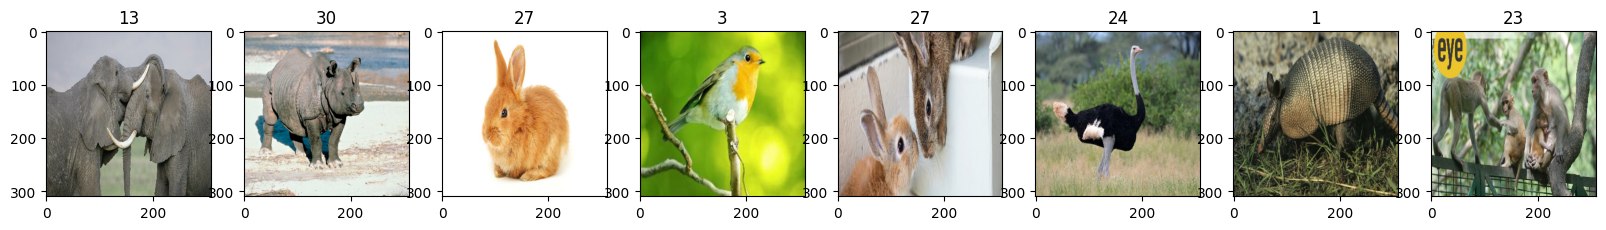

In [7]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [8]:
train_size = int(len(data)*.5)
val_size = int(len(data)*.3)+1
test_size = int(len(data)*.2)


In [9]:
train_size+val_size+test_size

327

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [11]:
print(len(train))

163


In [12]:
import tensorflow as tf

# Define augmentation functions
def random_flip(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

def random_rotation(image, label):
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    return image, label

def random_zoom(image, label):
    zoom_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    image_height = tf.cast(tf.shape(image)[0], tf.float32)  # Cast to float32
    image_width = tf.cast(tf.shape(image)[1], tf.float32)   # Cast to float32
    new_height = tf.cast(image_height * zoom_factor, tf.int32)
    new_width = tf.cast(image_width * zoom_factor, tf.int32)
    image = tf.image.resize(image, (new_height, new_width))
    image = tf.image.resize_with_crop_or_pad(image, tf.cast(image_height, tf.int32), tf.cast(image_width, tf.int32))  # Cast to int32
    return image, label


# Apply augmentation functions to the dataset
augmented_train_data = train.map(random_flip)
augmented_train_data = augmented_train_data.map(random_rotation)
augmented_train_data = augmented_train_data.map(random_zoom)

train=train.repeat()

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch <3:
        return lr
    else:
        return lr * np.exp(-0.1)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l2, l1


def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def VGG16(input_shape=(310, 310, 3), num_classes=39, l1_factor=0.01, l2_factor=0.01):
    model = Sequential()

    # Block 1
    # model.add(Conv2D(8, (3, 3), activation='elu', padding='same', input_shape=input_shape,))
    model.add(Conv2D(8, (3, 3), activation='elu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(.25))

    # Block 2
    # model.add(Conv2D(16, (3, 3), activation='elu', padding='same'))
    model.add(Conv2D(16, (3, 3), activation='elu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(.5))

    # Block 3
    # model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(Conv2D(32, (3,3), activation='elu', padding='same',))
    # model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='elu', padding='same', kernel_regularizer=l1(l1=l1_factor)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(.5))

    # Block 4
    # model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='elu', padding='same', ))
    # model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(.5))

    # Block 5
    # model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='elu', padding='same',))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='elu', padding='same', kernel_regularizer=l2(l2=l2_factor)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(2048, activation='elu'))
    tf.keras.layers.LeakyReLU(alpha=0.2),
    model.add(Dropout(.5))
    # model.add(Dense(512, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create VGG-16 model
model = VGG16(input_shape=(310, 310, 3), num_classes=39, l1_factor=0.01, l2_factor=0.01)
model.build(input_shape=(310, 310, 3))

# # Display model summary
model.summary()


ValueError: Input 0 of layer "conv2d_28" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (310, 310, 3)

In [23]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
validation_steps = len(val)//32
validation_steps

3

In [24]:
hist = model.fit(train, epochs=10, steps_per_epoch=250, validation_data=val, shuffle=True, batch_size =78, validation_batch_size=32, validation_steps=validation_steps)

Epoch 1/10
250/250 [==============================] - 38s 129ms/step - loss: 5.1328 - accuracy: 0.0868 - val_loss: 3.7114 - val_accuracy: 0.1146
Epoch 2/10
250/250 [==============================] - 32s 130ms/step - loss: 3.5069 - accuracy: 0.1351 - val_loss: 3.2659 - val_accuracy: 0.1667
Epoch 3/10
250/250 [==============================] - 32s 127ms/step - loss: 3.2641 - accuracy: 0.1755 - val_loss: 3.2925 - val_accuracy: 0.1875
Epoch 4/10
250/250 [==============================] - 32s 130ms/step - loss: 3.1544 - accuracy: 0.2198 - val_loss: 2.8517 - val_accuracy: 0.3021
Epoch 5/10
250/250 [==============================] - 32s 127ms/step - loss: 2.9915 - accuracy: 0.2751 - val_loss: 3.0961 - val_accuracy: 0.2708
Epoch 6/10
250/250 [==============================] - 32s 129ms/step - loss: 2.8693 - accuracy: 0.3322 - val_loss: 3.4767 - val_accuracy: 0.2604
Epoch 7/10
250/250 [==============================] - 31s 126ms/step - loss: 2.6321 - accuracy: 0.4275 - val_loss: 3.5513 - val_ac

In [ ]:
hyf()

In [ ]:
model.predict()

In [ ]:
# Assuming you have trained your model and stored it in a variable called 'model'

# Save the entire model to a HDF5 file
model.save("my_model11(almost).h5")


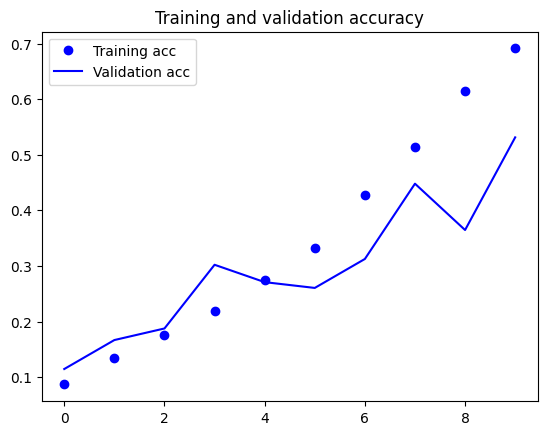

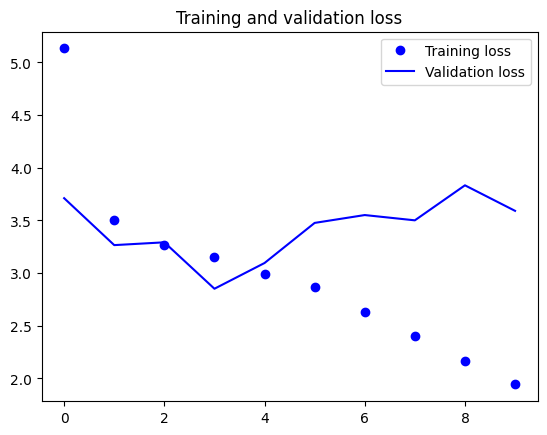

In [25]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

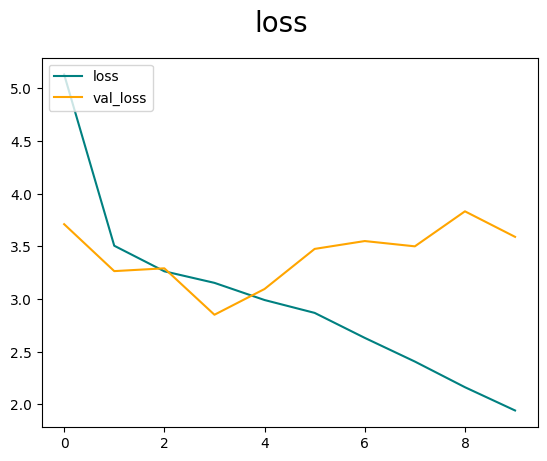

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

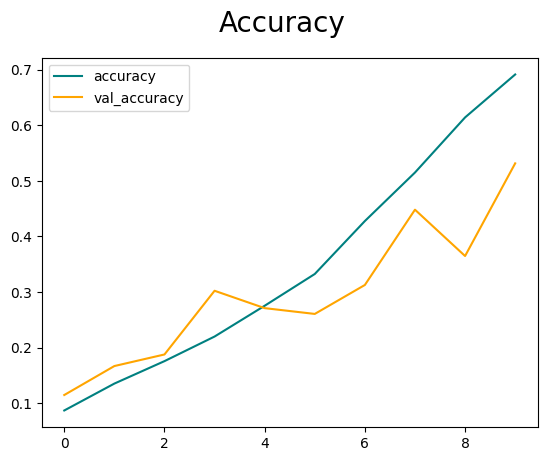

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre =Precision()
re = Recall()
acc = CategoricalAccuracy()

In [29]:
test_loss, test_accuracy = model.evaluate(test, steps =65)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

65/65 [==============================] - 18s 44ms/step - loss: 6.5415 - accuracy: 0.2138
Test Loss: 6.541543006896973
Test Accuracy: 0.21376636624336243


In [30]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import json

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(310, 310)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load the model
# model = tf.keras.models.load_model('path/to/your/model')

# Load the class to non-scientific name mapping
# with open('translation.json', 'r') as file:
#     class_to_non_scientific = json.load(file)

# Predict the class for a new image
image_path = 'gray-wolf.webp'
img_array = load_and_preprocess_image(image_path)
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_probability = np.max(predictions, axis=1)[0]  # Model's confidence
class_names = data_val.class_names
# Lookup the non-scientific name
# non_scientific_name = class_to_non_scientific.get(predicted_class_index, class_to_non_scientific.get(class_names[predicted_class_index]))
print(f"Predicted class index: {predicted_class_index}, Non-scientific name: {class_names[predicted_class_index]}, Confidence: {predicted_probability:.2%}")

1/1 [==============================] - 0s 188ms/step
Predicted class index: 2, Non-scientific name: bear, Confidence: 28.84%


In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import json

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(310, 310)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load the model
# model = tf.keras.models.load_model('path/to/your/model')

# Load the class to non-scientific name mapping
# with open('translation.json', 'r') as file:
#     class_to_non_scientific = json.load(file)

# Predict the class for a new image
image_path = 'C:/Users/joshu/OneDrive/Documents/machinelearning/cat.webp'
img_array = load_and_preprocess_image(image_path)
predictions = model.predict(img_array)[0]
top_three_indices = np.argsort(predictions)[::-1][:5]
top_three_probabilities = predictions[top_three_indices]
class_names = data_val.class_names
top_three_classes = [class_names[i] for i in top_three_indices]

for i in range(5):
    print(f"Top {i+1} Prediction: Class index: {top_three_indices[i]}, Non-scientific name: {top_three_classes[i]}, Probability: {top_three_probabilities[i]:.2%}")


1/1 [==============================] - 0s 15ms/step
Top 1 Prediction: Class index: 7, Non-scientific name: cat, Probability: 86.87%
Top 2 Prediction: Class index: 16, Non-scientific name: girafee, Probability: 12.53%
Top 3 Prediction: Class index: 32, Non-scientific name: sheep, Probability: 0.24%
Top 4 Prediction: Class index: 21, Non-scientific name: leopard, Probability: 0.16%
Top 5 Prediction: Class index: 22, Non-scientific name: lion, Probability: 0.03%
